<a href="https://colab.research.google.com/github/nadavru/iLearn/blob/iLearnML/notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [41]:
from abc import ABCMeta, abstractmethod
from IPython.display import IFrame

url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"

class Trainer:
    def __init__(self, grid_x, grid_y, lr=0.5, epochs=50): 
        self.lr=lr
        self.x_cur = 2*grid_x*np.random.random_sample()-grid_x
        self.y_cur = 2*grid_y*np.random.random_sample()-grid_y
        self.epochs=epochs

        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        x = np.linspace(-grid_x, grid_x, 1000)
        y = np.linspace(-grid_y, grid_y, 1000)
        self.X, self.Y = np.meshgrid(x, y)

    def __call__(self): 
        return self.X, self.Y, np.where(True, self.calc(self.X, self.Y), 0)
    
    def train(self): 
        self.Xs = [self.x_cur]
        self.Ys = [self.y_cur]
        self.Zs = [self.calc(self.x_cur, self.y_cur)]

        for _ in range(self.epochs):
            d = self.derive(self.x_cur, self.y_cur)
            print(d)
            self.x_cur -= self.lr*d[0]
            self.y_cur -= self.lr*d[1]

            self.Xs.append(self.x_cur)
            self.Ys.append(self.y_cur)
            self.Zs.append(self.calc(self.x_cur, self.y_cur))
        return self.Zs
    
    def display(self): 
        points_str = ""
        for i in range(len(self.Xs)):
          points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
        points_str=points_str[:-1]

        src=self.disp_url+f"func={self.func_str()}&points={points_str}"
        return src

        #IFrame(src=self.disp_url+f"func={self.func_str()}&points={points_str}", width=700, height=600)

    @abstractmethod
    def func_str(self): 
      pass
    
    @abstractmethod
    def calc(self, x, y): 
      pass

    @abstractmethod
    def derive(self, x, y): 
      pass

In [3]:
from math import exp

e = exp(1)

class Gaussian_helper: 
    def __init__(self, a, px, py, c=1): 
        self.a=a
        self.px=px
        self.py=py
        self.c=c

    def calc(self, x, y): 
        return -self.a*e**(-((x-self.px)**2+(y-self.py)**2)/(2*self.c**2))

    def derive(self, x, y): 
        tmp = (self.a/self.c**2)*e**(-((x-self.px)**2+(y-self.py)**2)/(2*self.c**2))
        return (tmp*(x-self.px), tmp*(y-self.py))

class Gaussian(Trainer):

    def __init__(self, apc:list, grid_x, grid_y, lr=0.5, epochs=50): 
        super().__init__(grid_x, grid_y, lr, epochs)
        self.g_list = [Gaussian_helper(*i) for i in apc]

        self.f_str = ""
        for a, px, py, c in apc:
            s_x = "-"+(str)(px) if px>0 else "+"+(str)(-px)
            s_y = "-"+(str)(py) if py>0 else "+"+(str)(-py)
            self.f_str += f"-{a}*e^(-((x{s_x})^2+(y{s_y})^2)/(2*{c}^2))"
        
    def calc(self, x, y): 
        return sum([G.calc(x, y) for G in self.g_list])

    def derive(self, x, y): 
        d_list = [G.derive(x, y) for G in self.g_list]
        return [sum(i) for i in zip(*d_list)]
        
    def func_str(self): 
      return self.f_str
    
    def points_str(self): 
      pass

In [44]:
#from mpmath import sech

class SVM(Trainer):

  def __init__(self, group_size, p0, p1, grid_X=100, grid_y=100, lr=0.5, epochs=10): 
        super().__init__(grid_x, grid_y, lr, epochs)
        (x0, y0, var0) = p0
        (x1, y1, var1) = p1
        self.group_size = group_size
        self.group0 = np.array(list(zip(list(np.random.normal(x0, var0, group_size)), list(np.random.normal(y0, var0, group_size)))))
        self.group1 = np.array(list(zip(list(np.random.normal(x1, var1, group_size)), list(np.random.normal(y1, var0, group_size)))))

        self.X, self.Y = np.concatenate((self.group0[:,0],self.group1[:,0])), np.concatenate((self.group0[:,1],self.group1[:,1]))

  def calc(self, x, y): 
    act0 = np.tanh(x*self.group0[:,0]+y*self.group0[:,1])+1
    act1 = 1-np.tanh(x*self.group1[:,0]+y*self.group1[:,1])

    loss = (np.sum(act0)+np.sum(act1))/(2*self.group_size)
    return loss
  
  def derive(self, x, y): 
    der0 = 1/(2*self.group_size*np.cosh(x*self.group0[:,0]+y*self.group0[:,1])**2)
    der1 = -1/(2*self.group_size*np.cosh(x*self.group1[:,0]+y*self.group1[:,1])**2)
    dx = np.sum(self.group0[:,0]*der0) + np.sum(self.group1[:,0]*der1)
    dy = np.sum(self.group0[:,1]*der0) + np.sum(self.group1[:,1]*der1)

    return [dx, dy]

    

In [45]:
T = SVM(500, (1,1,50), (-1,-1,50))
print(T.train())

[0.00012135899115069461, -9.578082069935721e-05]
[0.00012098648510742908, -9.54868362233972e-05]
[0.00012061621878723484, -9.519461923410338e-05]
[0.00012024817249226414, -9.490415418857442e-05]
[0.00011988232674850854, -9.461542572050182e-05]
[0.00011951866230283644, -9.432841863783327e-05]
[0.0001191571601199531, -9.404311792037527e-05]
[0.00011879780137947247, -9.375950871748327e-05]
[0.00011844056747295258, -9.34775763457237e-05]
[0.00011808544000098587, -9.319730628657886e-05]
[1.0020038456991553, 1.0020038337665205, 1.0020038219069718, 1.0020038101198474, 1.002003798404494, 1.0020037867602651, 1.0020037751865227, 1.0020037636826356, 1.0020037522479803, 1.002003740881941, 1.0020037295839086]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


In [46]:
X, Y, Z = T()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))

ValueError: ignored

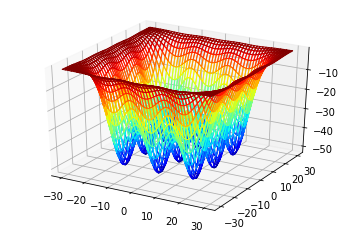

In [4]:
from matplotlib import cm

sizes = []
for ix in [-15,0,15]:
  for iy in [-15,0,15]:
    sizes.append((50,ix,iy,5))

grid_x = 30
grid_y = 30

G = Gaussian(sizes, grid_x, grid_y)

X, Y, Z = G()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))

In [5]:
G.train()

In [7]:
src = G.display()
#print(src)

IFrame(src=src, width=700, height=600)